In [4]:
import os
from os.path import join as oj
import sys, time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data_pecarn
import data_psrc
import data
import train
import matplotlib.gridspec as grd
from data import feats_numerical, feats_categorical, meta

# sns.set(style="black")
# plt.style.use('dark_background')
outcome_def = 'iai_intervention' # output
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# prepare data

In [5]:
df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=True)
df = df_pecarn[common_feats].append(df_psrc[common_feats])
processed_feats = data.select_final_feats(common_feats)

computing pecarn preprocessing...
computing psrc preprocessing...


In [6]:
train_idxs = data.pecarn_train_idxs
test_idxs1 = data.pecarn_test_idxs
test_idxs2 = data.psrc_train_idxs + data.psrc_test_idxs
df = df[df.cv_fold.isin(train_idxs)]

In [7]:
print(len(processed_feats), processed_feats)

26 ['MOI_Bike collision/fall', 'ThoracicTrauma_yes', 'VomitWretch_unknown', 'MOI_Motor vehicle collision', 'Age', 'DecrBreathSound_yes', 'AbdDistention_yes', 'RtCostalTender', 'AbdomenPain_yes', 'InitHeartRate', 'MOI_Motorcycle/ATV/Scooter collision', 'AbdTenderDegree_Severe', 'AbdTenderDegree_Moderate', 'MOI_Fall from an elevation', 'InitSysBPRange', 'MOI_Pedestrian/bicyclist struck by moving vehicle', 'MOI_unknown', 'GCSScore_Full_yes', 'LtCostalTender', 'CostalTender', 'MOI_Object struck abdomen', 'AbdTrauma_or_SeatBeltSign_yes', 'VomitWretch_yes', 'AbdTenderDegree_Mild', 'AbdDistention_unknown', 'Hypotension_yes']


In [ ]:
print(train_idxs, test_idxs1, test_idxs2)

# predict

In [22]:
from sklearn.metrics import precision_recall_curve

X, y = df[processed_feats], df[outcome_def]

X_train, y_train = X[:len(y)//2], y[:len(y)//2]
X_test, y_test = X[len(y)//2:], y[len(y)//2:]


In [18]:
from imodels import RuleListClassifier, RuleFit
from skrules import SkopeRules

In [19]:
# feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
clf = SkopeRules(max_depth_duplication=3,
                 n_estimators=30,
                 precision_min=0.3,
                 recall_min=0.1,
                 feature_names=processed_feats)

In [ ]:
clf.fit(X_train, y_train)

Rules for iai
('AbdTenderDegree_Severe > 0.5 and InitSysBPRange <= 128.0 and InitHeartRate > 111.5', (0.5652173913043478, 0.19117647058823528, 1))
('AbdTrauma_or_SeatBeltSign_yes > 0.5 and Hypotension_yes <= 0.5 and AbdDistention_yes > 0.5', (0.309863339275104, 0.1570048309178744, 3))
('AbdTenderDegree_Severe <= 0.5 and LtCostalTender > 2.5 and AbdDistention_yes > 0.5', (0.3270474137931034, 0.14687432403201384, 2))
('AbdTenderDegree_Severe > 0.5 and AbdDistention_yes <= 0.5 and InitHeartRate > 111.5', (0.3385989010989011, 0.14359034865199694, 3))


/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


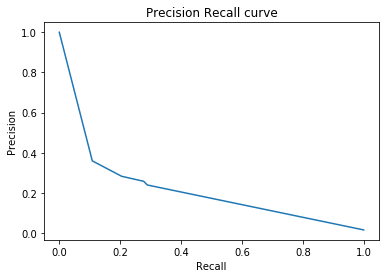

In [27]:
# print the rules
rules = clf.rules_
print("Rules for iai")
for rule in rules:
    print(rule)

# evaluate
y_score = clf.score_top_rules(X_test) # Get a risk score for each test example
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall curve')
plt.show()